# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

### NLTK Import

To prevent errors that may occur based on OS - we'll import NLTK and download the needed packages to ensure correct handling of data.

In [6]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nubyraahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nubyraahmed/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [56]:
import os
from dotenv import load_dotenv
from uuid import uuid4

from pathlib import Path
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

os.environ["LANGCHAIN_TRACING_V2"] = os.getenv("LANGCHAIN_TRACING_V2")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")

We'll also want to set a project name to make things easier for ourselves.

OpenAI's API Key!

In [57]:
# Set the environment variable explicitly
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# Verify it's loaded
print("API Key loaded:", bool(os.getenv("OPENAI_API_KEY")))

API Key loaded: True


In [15]:
from langchain_openai import ChatOpenAI

try:
    llm = ChatOpenAI(model="gpt-4.1-nano")
    response = llm.invoke("Hello, test message")
    print("API key is working!")
    print(response.content)
except Exception as e:
    print(f"API key error: {e}")

API key error: Error code: 401 - {'error': {'message': "You didn't provide an API key. You need to provide your API key in an Authorization header using Bearer auth (i.e. Authorization: Bearer YOUR_KEY), or as the password field (with blank username) if you're accessing the API from your browser and are prompted for a username and password. You can obtain an API key from https://platform.openai.com/account/api-keys.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - which should hopefull be familiar at this point since it's our Use-Case Data!

Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [7]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader


path = "data/"
loader = DirectoryLoader(path, glob="*.pdf", loader_cls=PyMuPDFLoader)
docs = loader.load()

In [8]:
len(docs)

64

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [12]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [13]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [14]:
from ragas.testset.graph import Node, NodeType

### NOTICE: We're using a subset of the data for this example - this is to keep costs/time down.
for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 64, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [15]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

Applying SummaryExtractor:   0%|          | 0/38 [00:00<?, ?it/s]

Property 'summary' already exists in node '040cb5'. Skipping!
Property 'summary' already exists in node 'e0a6f1'. Skipping!
Property 'summary' already exists in node '2cc261'. Skipping!
Property 'summary' already exists in node '63c27d'. Skipping!
Property 'summary' already exists in node '92f45e'. Skipping!
Property 'summary' already exists in node '34b06b'. Skipping!
Property 'summary' already exists in node 'bb1c2e'. Skipping!
Property 'summary' already exists in node '26ef86'. Skipping!
Property 'summary' already exists in node '05ebb4'. Skipping!
Property 'summary' already exists in node 'd2e9dc'. Skipping!
Property 'summary' already exists in node 'fce780'. Skipping!
Property 'summary' already exists in node 'b1136e'. Skipping!
Property 'summary' already exists in node 'db4eec'. Skipping!
Property 'summary' already exists in node 'de94c8'. Skipping!
Property 'summary' already exists in node '5b889a'. Skipping!
Property 'summary' already exists in node 'ae1d27'. Skipping!
Property

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/48 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'b1136e'. Skipping!
Property 'summary_embedding' already exists in node '92f45e'. Skipping!
Property 'summary_embedding' already exists in node '040cb5'. Skipping!
Property 'summary_embedding' already exists in node 'bb1c2e'. Skipping!
Property 'summary_embedding' already exists in node '2cc261'. Skipping!
Property 'summary_embedding' already exists in node 'e0a6f1'. Skipping!
Property 'summary_embedding' already exists in node '34b06b'. Skipping!
Property 'summary_embedding' already exists in node '26ef86'. Skipping!
Property 'summary_embedding' already exists in node '63c27d'. Skipping!
Property 'summary_embedding' already exists in node 'fce780'. Skipping!
Property 'summary_embedding' already exists in node '05ebb4'. Skipping!
Property 'summary_embedding' already exists in node 'd2e9dc'. Skipping!
Property 'summary_embedding' already exists in node 'db4eec'. Skipping!
Property 'summary_embedding' already exists in node 'de94c8'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 86, relationships: 712)

We can save and load our knowledge graphs as follows.

In [16]:
kg.save("usecase_data_kg.json")
usecase_data_kg = KnowledgeGraph.load("usecase_data_kg.json")
usecase_data_kg

KnowledgeGraph(nodes: 86, relationships: 712)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [17]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=usecase_data_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [18]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.

Generating personas:

It imagines different types of people (like a student, researcher, or casual user) and generates questions that each persona might ask based on their background, expertise level, and needs.

Generating Scenarios:

It sets up realistic scenarios (like "during a research project" or "while learning about a topic") and generates questions that would naturally arise in those situations. It's like creating the "scene" where the question gets asked.

Generating Samples:

This is the final step where it actually writes out the questions and their corresponding answers, using the personas and scenarios as guidance. It's like the "final product" - the actual test questions that will be used to evaluate your RAG system.





Finally, we can use our `TestSetGenerator` to generate our testset!

In [19]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What is the significance of the term Suh in th...,[Introduction ChatGPT launched in November 202...,The provided context does not include any info...,single_hop_specifc_query_synthesizer
1,What significance does June 2025 hold in the c...,[Table 1: ChatGPT daily message counts (millio...,June 2025 is used as a reference point for the...,single_hop_specifc_query_synthesizer
2,What is management and business?,[Variation by Occupation Figure 23 presents va...,Management and business are broad occupation c...,single_hop_specifc_query_synthesizer
3,How does management influence ChatGPT usage pa...,[Conclusion This paper studies the rapid growt...,The provided context does not specify how mana...,single_hop_specifc_query_synthesizer
4,"H0w do user demograph1cs and usage patterns, e...",[<1-hop>\n\nConclusion This paper studies the ...,"The context indicates that by July 2025, over ...",multi_hop_abstract_query_synthesizer
5,how user demo and usage patterns grow across p...,[<1-hop>\n\nConclusion This paper studies the ...,The context shows that ChatGPT launched in Nov...,multi_hop_abstract_query_synthesizer
6,how non-work msgs grow fast and work msgs less...,[<1-hop>\n\nMonth Non-Work (M) (%) Work (M) (%...,"In June 2024, non-work messages made up 53% of...",multi_hop_abstract_query_synthesizer
7,"Based on the rapid growth of ChatGPT, which ha...",[<1-hop>\n\nConclusion This paper studies the ...,"The widespread adoption of ChatGPT, with over ...",multi_hop_specific_query_synthesizer
8,Based on the rapid growth of ChatGPT usage in ...,[<1-hop>\n\nConclusion This paper studies the ...,"The context indicates that by July 2025, ChatG...",multi_hop_specific_query_synthesizer
9,Based on the findings of Handa et al. (2025) r...,[<1-hop>\n\nTable 1: ChatGPT daily message cou...,Handa et al. (2025) report that ChatGPT's usag...,multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [20]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/21 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/64 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

Applying SummaryExtractor:   0%|          | 0/38 [00:00<?, ?it/s]

Property 'summary' already exists in node '7e8575'. Skipping!
Property 'summary' already exists in node '2342d7'. Skipping!
Property 'summary' already exists in node 'a95cdd'. Skipping!
Property 'summary' already exists in node '2f9ca6'. Skipping!
Property 'summary' already exists in node 'f0fe14'. Skipping!
Property 'summary' already exists in node '853dce'. Skipping!
Property 'summary' already exists in node '82fdb3'. Skipping!
Property 'summary' already exists in node 'f99692'. Skipping!
Property 'summary' already exists in node '7974d7'. Skipping!
Property 'summary' already exists in node '5d6637'. Skipping!
Property 'summary' already exists in node '330771'. Skipping!
Property 'summary' already exists in node '5ac03e'. Skipping!
Property 'summary' already exists in node '80f834'. Skipping!
Property 'summary' already exists in node '38c9a2'. Skipping!
Property 'summary' already exists in node '41c238'. Skipping!
Property 'summary' already exists in node 'cd5895'. Skipping!
Property

Applying CustomNodeFilter:   0%|          | 0/8 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/48 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'f0fe14'. Skipping!
Property 'summary_embedding' already exists in node '2f9ca6'. Skipping!
Property 'summary_embedding' already exists in node 'a95cdd'. Skipping!
Property 'summary_embedding' already exists in node '7e8575'. Skipping!
Property 'summary_embedding' already exists in node '7974d7'. Skipping!
Property 'summary_embedding' already exists in node '2342d7'. Skipping!
Property 'summary_embedding' already exists in node '5d6637'. Skipping!
Property 'summary_embedding' already exists in node '82fdb3'. Skipping!
Property 'summary_embedding' already exists in node '5ac03e'. Skipping!
Property 'summary_embedding' already exists in node '330771'. Skipping!
Property 'summary_embedding' already exists in node '853dce'. Skipping!
Property 'summary_embedding' already exists in node 'f99692'. Skipping!
Property 'summary_embedding' already exists in node '80f834'. Skipping!
Property 'summary_embedding' already exists in node '37c46e'. Sk

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [21]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How does the number of 700 million users refle...,[Introduction ChatGPT launched in November 202...,"By July 2025, 700 million users were sending a...",single_hop_specifc_query_synthesizer
1,Tell me about June 2024 and how it is like in ...,[Table 1: ChatGPT daily message counts (millio...,"The context explains that in June 2024, ChatGP...",single_hop_specifc_query_synthesizer
2,What is a section in the context of ChatGPT us...,[Variation by Occupation Figure 23 presents va...,The context does not define 'Section' explicit...,single_hop_specifc_query_synthesizer
3,How do Relationships affect ChatGPT usage?,[Conclusion This paper studies the rapid growt...,The provided context does not include any info...,single_hop_specifc_query_synthesizer
4,how ChatGPT launch and how AI tech spread worl...,[<1-hop>\n\nIntroduction ChatGPT launched in N...,ChatGPT was launched in November 2022 and quic...,multi_hop_abstract_query_synthesizer
5,Based on the increase in total ChatGPT message...,[<1-hop>\n\nMonth Non-Work (M) (%) Work (M) (%...,The data shows that total ChatGPT messages gre...,multi_hop_abstract_query_synthesizer
6,How do the AI capabilities of ChatGPT influenc...,[<1-hop>\n\nIntroduction ChatGPT launched in N...,"The context indicates that ChatGPT, based on a...",multi_hop_abstract_query_synthesizer
7,How has the increasing use of ChatGPT outside ...,[<1-hop>\n\nTable 1: ChatGPT daily message cou...,The context indicates that non-work-related Ch...,multi_hop_abstract_query_synthesizer
8,"How do the 700 million users of ChatGPT, as me...",[<1-hop>\n\nConclusion This paper studies the ...,"The two segments indicate that by July 2025, C...",multi_hop_specific_query_synthesizer
9,how many users are useing chatgpt with 700 mil...,[<1-hop>\n\nConclusion This paper studies the ...,"According to the context, by July 2025, ChatGP...",multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [22]:
from langsmith import Client

client = Client()

dataset_name = "Use Case Synthetic Data - AIE8"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="Synthetic Data for Use Cases"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [23]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [24]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [25]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [26]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [27]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Use Case RAG"
)

In [28]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [29]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

As is usual: We'll be using `gpt-4.1-mini` for our RAG!

In [30]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-mini")

Finally, we can set-up our RAG LCEL chain!

In [31]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [32]:
rag_chain.invoke({"question" : "What are people doing with AI these days?"})

'Based on the provided context, people are using AI, particularly generative AI like ChatGPT, in a variety of ways both at work and outside of work. Key uses include:\n\n- Performing workplace tasks by either augmenting or automating human labor.\n- Producing writing, software code, spreadsheets, and other digital products, tasks that distinguish generative AI from traditional technologies.\n- Seeking information and advice, similar to web search engines, but with added flexibility.\n- Using AI as co-workers that produce output or as co-pilots that give advice and improve human problem-solving productivity.\n- Engaging in self-expression activities like relationships, personal reflection, games, and role play (though these constitute a smaller proportion of usage).\n- Therapy and companionship as notable uses of generative AI (as estimated by external research cited).\n  \nOverall, AI is highly flexible and is being integrated both for economic activities—augmenting professional and oc

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4.1 as our evaluation LLM for our base Evaluators.

In [33]:
eval_llm = ChatOpenAI(model="gpt-4.1")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [34]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this response dope, lit, cool, or is it just a generic response?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:

What it evaluates: The quality of question-answer pairs generated by your RAG system.

Evaluates the quality of question-answer pairs by measuring how well the generated answers address the original questions and how accurate they are based on the provided context. It typically uses metrics like answer relevancy, faithfulness, and context precision to score the performance of your RAG system's responses.


- `labeled_helpfulness_evaluator`:

What it evaluates: How helpful the generated answers are to users.
Specific focus:
Helpfulness score - 
Does the answer actually help solve the user's query and how does it compare to the reference answer. 

- `dopeness_evaluator`:

What it evaluates: How "open" or comprehensive and cool or just generic - kind of vague and doesn't make much sense. 
Specific aspects:
"Is this response dope, lit, cool, or is it just a generic response?"

## LangSmith Evaluation

In [35]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dopeness_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'artistic-fact-41' at:
https://smith.langchain.com/o/34e95035-48c8-49d2-b345-f38fde9e5e3f/datasets/5d1a40c7-a6cf-4740-a9e5-e591a7dda7c4/compare?selectedSessions=53ea4331-1a88-4229-a376-352810a8d609




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,"Based on the findings of Handa et al. (2025), ...",I don't know.,None,Handa et al. (2025) report that nearly 80% of ...,0,0,0,0.662387,c114283c-05ff-4f4f-bd3d-43f32eda02a7,b6a1fdd6-6ceb-4569-b5b5-bc8934aa1392
1,"Whay does Handa et al., 2025, say about ChatGP...","Handa et al., 2025, emphasize that their work ...",None,"Handa et al., 2025, report that ChatGPT usage ...",0,0,0,1.398608,a5ebea4f-07a3-4ca2-b506-a85ff2ea1b99,aae6b8a5-814b-47eb-8ed6-0c85f36c9275
2,how many users are useing chatgpt with 700 mil...,"By the end of July 2025, ChatGPT had more than...",None,"According to the context, by July 2025, ChatGP...",1,1,0,1.423686,fc4b52fd-5b6f-4b55-985f-f57a72ade3d7,d8bedeb3-94e5-4297-a221-2947313840d5
3,"How do the 700 million users of ChatGPT, as me...",The 700 million weekly active users of ChatGPT...,None,"The two segments indicate that by July 2025, C...",1,1,0,3.993238,b5172110-cae2-44b7-8cc5-bd2e28b4ffbb,95bff9ac-d3ca-4669-9438-f3b4f8a7b619
4,How has the increasing use of ChatGPT outside ...,The increasing use of ChatGPT outside of work ...,None,The context indicates that non-work-related Ch...,1,1,0,2.409036,49f4f1d0-fa5c-40df-bdbe-2360c037f4e5,c2178cb6-6862-4b21-8f50-6dd0a68fd04f
5,How do the AI capabilities of ChatGPT influenc...,"Based on the provided context, ChatGPT's AI ca...",None,"The context indicates that ChatGPT, based on a...",1,1,0,4.609357,0ad7743b-b47b-45c4-9c2b-c3f5ca9f8f5c,6bec7288-2e67-4092-b13e-fcaf98156575
6,Based on the increase in total ChatGPT message...,"Based on the provided context, the increase in...",None,The data shows that total ChatGPT messages gre...,1,1,0,4.724594,39dde0ad-af31-45dc-a3ac-7f38018fc419,6c913d4d-fb1f-4944-b786-508700aee8d9
7,how ChatGPT launch and how AI tech spread worl...,ChatGPT launched in November 2022 and rapidly ...,None,ChatGPT was launched in November 2022 and quic...,1,1,0,12.063607,1ac0da8a-5fe3-4631-95cb-09ea47d290e9,81407e94-2617-4ea7-9000-bde0fd59907e
8,How do Relationships affect ChatGPT usage?,"Based on the provided context, only a small sh...",None,The provided context does not include any info...,0,0,0,1.331282,2f126231-c174-4e9a-a203-58da94fd4d6d,c1da79ee-59b6-469d-88b7-708f00b034f2
9,What is a section in the context of ChatGPT us...,A section in the context of ChatGPT usage data...,None,The context does not define 'Section' explicit...,0,0,0,0.935468,fe90e7d0-7974-4744-8e47-8446cef6a574,916ff3ca-aa27-4e78-9feb-f0cbc28f79fb


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [36]:
DOPENESS_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Make your answer rad, ensure high levels of dopeness. Do not be generic, or give generic responses.

Context: {context}
Question: {question}
"""

dopeness_rag_prompt = ChatPromptTemplate.from_template(DOPENESS_RAG_PROMPT)

In [37]:
rag_documents = docs

In [38]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

Modifying chunk size affects RAG performance because it directly impacts both retrieval accuracy and context relevance. Smaller chunks provide more precise matches but may lack sufficient context, while larger chunks offer more comprehensive context but can introduce irrelevant information that dilutes the answer quality.
The optimal chunk size depends on your specific use case - you need to balance between having enough context to answer questions completely while avoiding noise that could confuse the model or reduce the precision of your retrievals.

In [39]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

Modifying your embedding model affects RAG performance because different models have varying capabilities in semantic understanding and dimensional representation. A better embedding model can capture more nuanced relationships between your documents and queries, leading to more accurate retrieval of relevant chunks, while a weaker model might miss important semantic connections or produce embeddings that don't align well with your specific domain.
The choice of embedding model directly impacts retrieval quality - models trained on different data or with different architectures will represent the same text differently, which can significantly change which documents get retrieved for a given query and ultimately affect the accuracy and relevance of your RAG system's responses.

In [45]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="Use Case RAG Docs"
)

In [46]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [47]:
dopeness_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dopeness_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [48]:
dopeness_rag_chain.invoke({"question" : "How are people using AI to make money?"})

'Alright, let’s crank this up to eleven and drop the dank knowledge bomb straight from the AI vault! 🚀\n\nBased on the context in **"How People Use ChatGPT,"** people ain\'t just using AI to slap tasks onto autopilot—they’re flexing AI as a **brainy advisor and research sidekick** that turbocharges their decision-making. This is straight fire for knowledge-intensive hustles where top-notch decision-making is the secret sauce to leveling up productivity. 🌟\n\nSo, how does this translate to making the green? Users **leverage ChatGPT to boost their work output by getting smarter decisions faster**—think of it as having a genius co-pilot that helps you strategize, problem-solve, and brainstorm like a pro. In other words, AI is not just doing the grind but **amplifying the quality of work you deliver**, making your skills sharper and your job performance glow-up real.\n\nAnd hold up—Collis and Brynjolfsson (2025) put a dollar sign on this vibe: US users would need way over **$98 bucks a mon

Finally, we can evaluate the new chain on the same test set!

In [49]:
evaluate(
    dopeness_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dopeness_evaluator
    ],
    metadata={"revision_id": "dopeness_rag_chain"},
)

View the evaluation results for experiment: 'back-design-13' at:
https://smith.langchain.com/o/34e95035-48c8-49d2-b345-f38fde9e5e3f/datasets/5d1a40c7-a6cf-4740-a9e5-e591a7dda7c4/compare?selectedSessions=00e39e5f-84b6-47fa-89d9-36f48c9e7d8b




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,"Based on the findings of Handa et al. (2025), ...","Yo, buckle up—Handa et al. (2025) drop some se...",None,Handa et al. (2025) report that nearly 80% of ...,1,1,1,6.197745,c114283c-05ff-4f4f-bd3d-43f32eda02a7,0a307c71-b801-4707-8f33-c0db36597737
1,"Whay does Handa et al., 2025, say about ChatGP...","Yo, diving into the cosmic depths of the conte...",None,"Handa et al., 2025, report that ChatGPT usage ...",1,0,1,3.481267,a5ebea4f-07a3-4ca2-b506-a85ff2ea1b99,a876d766-da36-469f-bde1-0e880816d1a8
2,how many users are useing chatgpt with 700 mil...,"Hold onto your hats — by the end of July 2025,...",None,"According to the context, by July 2025, ChatGP...",1,1,1,2.500949,fc4b52fd-5b6f-4b55-985f-f57a72ade3d7,2c5aa56a-f07b-47ac-96a4-e5eacb9c13e3
3,"How do the 700 million users of ChatGPT, as me...","Alright, let’s unpack the mind-blowing ascent ...",None,"The two segments indicate that by July 2025, C...",1,1,1,6.322614,b5172110-cae2-44b7-8cc5-bd2e28b4ffbb,8cafbafb-f69b-4dd4-82f0-455ba6740415
4,How has the increasing use of ChatGPT outside ...,"Yo, here’s the scoop straight from the digital...",None,The context indicates that non-work-related Ch...,1,1,1,3.842000,49f4f1d0-fa5c-40df-bdbe-2360c037f4e5,f59b3963-a57a-465d-a3fc-ddab32fd8a0a
5,How do the AI capabilities of ChatGPT influenc...,"Alright, strap in because this insight about C...",None,"The context indicates that ChatGPT, based on a...",1,1,1,5.704284,0ad7743b-b47b-45c4-9c2b-c3f5ca9f8f5c,effd92f0-90d0-497d-83c1-cb26323f2741
6,Based on the increase in total ChatGPT message...,"Alright, strap in for this AI knowledge drop —...",None,The data shows that total ChatGPT messages gre...,1,1,1,6.730671,39dde0ad-af31-45dc-a3ac-7f38018fc419,4a10955c-7532-41da-8aac-616b7f8a1101
7,how ChatGPT launch and how AI tech spread worl...,"Alright, buckle up for the ultimate story on h...",None,ChatGPT was launched in November 2022 and quic...,1,1,1,16.949548,1ac0da8a-5fe3-4631-95cb-09ea47d290e9,fcf849dd-80f2-4492-84c9-58980a1790c8
8,How do Relationships affect ChatGPT usage?,"Yo, here’s the skinny on Relationships and Cha...",None,The provided context does not include any info...,0,0,1,3.357666,2f126231-c174-4e9a-a203-58da94fd4d6d,905a727f-9efd-40d8-affc-4287bc81698f
9,What is a section in the context of ChatGPT us...,"Whoa, buckle up—here’s the lowdown straight fr...",None,The context does not define 'Section' explicit...,0,0,1,4.734201,fe90e7d0-7974-4744-8e47-8446cef6a574,6bb7fd2c-cf08-4d2e-8a57-f2ac4b65f878


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

=== BEFORE (Original Chain) ===


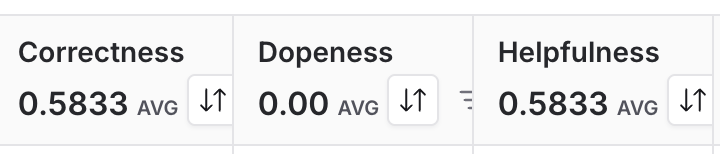


=== AFTER (Modified Chain) ===


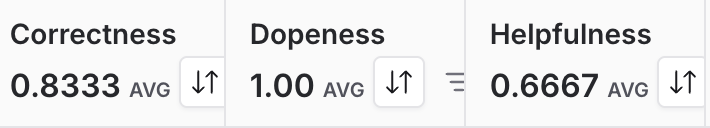

In [55]:
from signal import siginterrupt
from IPython.display import Image, display

print("=== BEFORE (Original Chain) ===")
display(Image('data/before.png', width=400))

print("\n=== AFTER (Modified Chain) ===")
display(Image('data/after.png', width=400))

**Metric Changes Analysis**


**Dopeness: 100% Improvement**

Reached 100% because the prompt explicitly instructed "Make your answer rad, ensure high levels of dopeness. Do not be generic." This direct optimization aligned the model's output perfectly with dopeness evaluation criteria.

**Correctness: Significant Improvement**

Improved due to three factors:

Better embedding model - More accurate document retrieval

Larger chunks with overlap - More comprehensive context without losing information

"I don't know" instruction - Prevented hallucination by keeping responses within provided context

**Helpfulness: Moderate Improvement**

Improved from better information quality and more engaging responses, but didn't reach 100% because the system lacks user-specific context needed for maximum helpfulness.